# Generación de Curvas de Ingreso EHPM 2019
En este notebook encontrarás el código para la generación de curvas de ingreso basados en la data de la EHPM 2019.

Descarga la base de datos en formato [CSV desde este link](https://drive.google.com/file/d/1tEosrGjmoN7sxeaGtDEk673YikNAfvcs/view) y descomprimela dentro de la carpeta EHPM2019.

In [1]:
import pandas as pd
ehpm2019 = pd.read_csv("../EHPM2019/EHPM 2019.csv",encoding='UTF-8',low_memory=False)


Checkeo de sanidad: Revisamos si el total del ingreso promedio por hogar coincide con el reporte de la EHPM ($620USD).

In [2]:
(ehpm2019[ehpm2019.r101==1]['ingfa'] * ehpm2019[ehpm2019.r101==1]['fac00']).sum()/ehpm2019[ehpm2019.r101==1]['fac00'].sum()

619.8995518321117

La base de datos contiene un factor de expansión correspondiente al número de hogares representados por cada muestra. Este algoritmo se encarga de agrupar los hogares en percentiles ordenados por el ingreso.

In [3]:
sorted_income = ehpm2019[ehpm2019.r101==1].filter(['fac00','ingfa']).sort_values(by='ingfa', ignore_index=True)
total_hh = ehpm2019[ehpm2019.r101==1]['fac00'].sum()
bins = 100 # Total de n-tiles
bin_size = total_hh/bins # Tamaño de cada n-til (Approx 19,400 hogares)


In [4]:
households = 0
income = 0
segment = 0

chart_data = []

# Variable temporal de almacenamiento de los percentiles y de las proporciones de ingreso
incomeCurve = pd.DataFrame(chart_data, columns = ['100%','75%','50%','25%','segmento'], index=[])
                           
# Este algoritmo ocupa el factor de expansión (fac00) y va contando el número de hogares
# que corresponden a cada percentil. Como el punto de corte del percentil puede quedar
# en medio de un rango cubierto por el factor de expansión. El algoritmo se encarga de
# asignar correscamente el número de hogares y el ingreso correspondiente al segmento.
# Luego de eso se calcula el promedio para el segmento y se agrega a la variable temporal.

# Esta no es la versión más optima del algoritmo y puede simplificarse
for i in range(0, len(sorted_income)):
    households += sorted_income.at[i,'fac00']
    
    segment_total = sorted_income.at[i, 'ingfa']*sorted_income.at[i, 'fac00']
    if households >= bin_size:
        # Split totals
        proportion = (households-bin_size)/bin_size
        income += proportion*segment_total
        avg_income_segment = income/bin_size
        incomeCurve = incomeCurve.append({
            '100%' : avg_income_segment ,
            '75%' : avg_income_segment*0.75,
            '50%' : avg_income_segment*0.50,
            '25%' : avg_income_segment*0.25,
            'segmento' : segment
            } , ignore_index=True)
        # Add the remanent to the next segment
        households = (1-proportion)*sorted_income.at[i, 'fac00']
        income = (1-proportion)*segment_total
        segment += 1
    else:
        income += segment_total

if households<bin_size:
    avg_income_segment = income/bin_size
    incomeCurve = incomeCurve.append({
        '100%' : avg_income_segment ,
        '75%' : avg_income_segment*0.75,
        '50%' : avg_income_segment*0.50,
        '25%' : avg_income_segment*0.25,
        'segmento' : segment
        } , ignore_index=True)

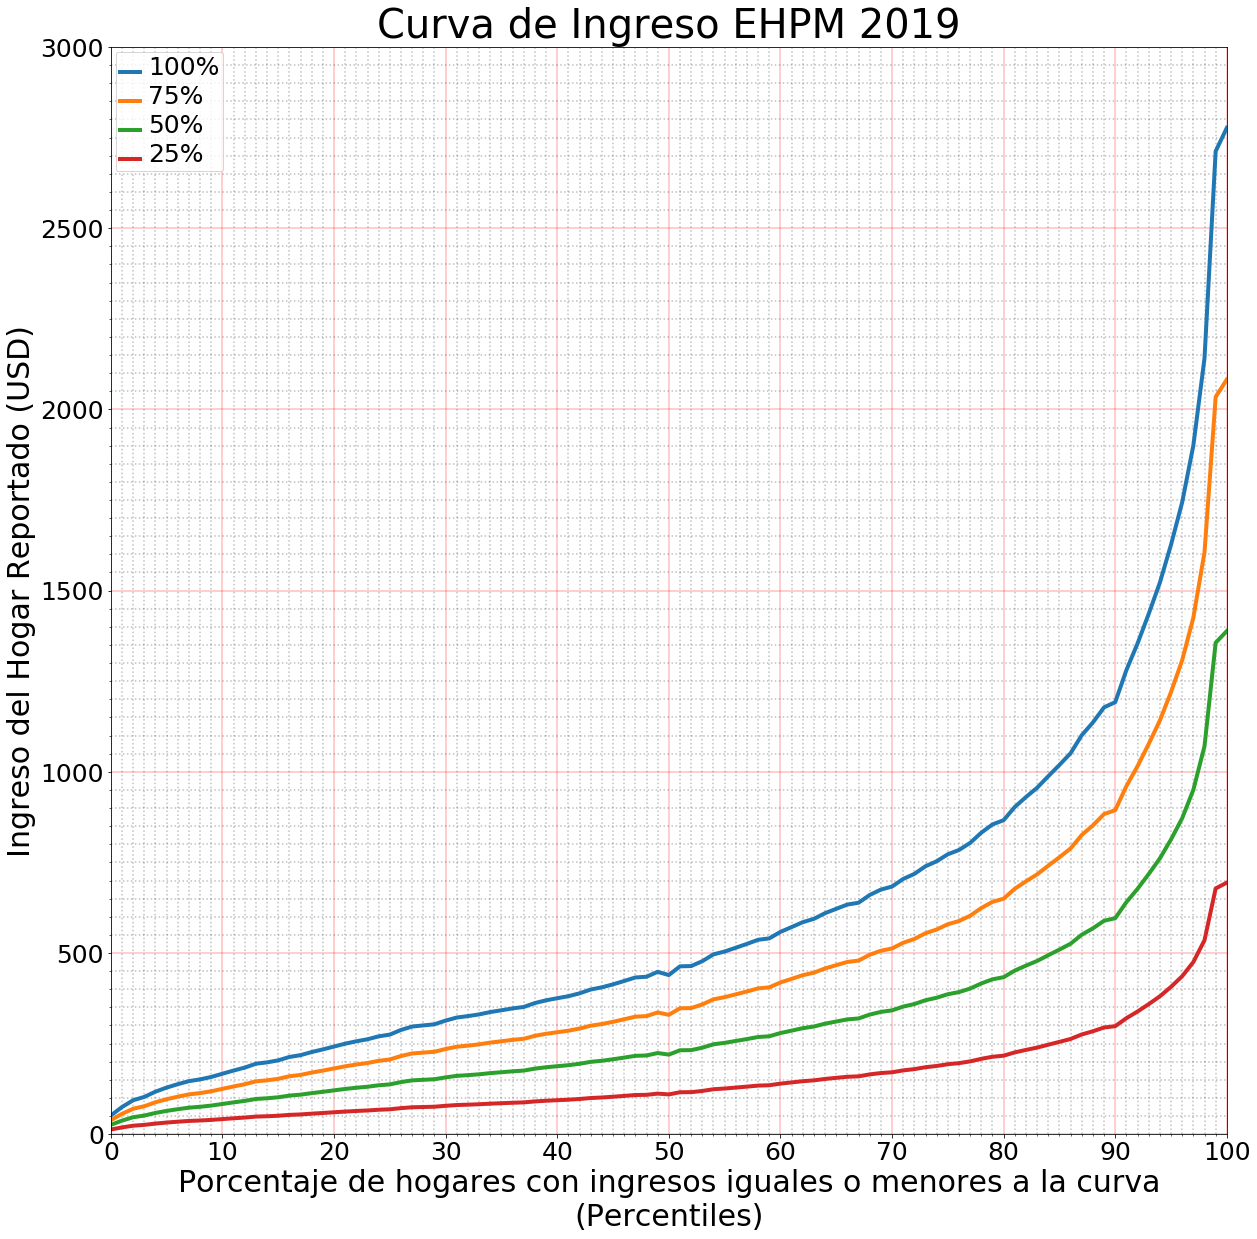

In [7]:
# Toda esta sección son comandos para graficar el resultado
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.cm as cm
fig, ax = plt.subplots()
incomeCurve.plot(x='segmento',y=['100%','75%','50%','25%'],figsize=(20,20),ylim=(0,3000), xlim=(0,100), ax=ax)
# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='1.5', color='red', alpha=0.25)
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='1.5', color='black', alpha=0.25)

locator = ticker.LinearLocator(11)
locatorb = ticker.LinearLocator(101)

locatorc = ticker.LinearLocator(61)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(locatorb)
ax.yaxis.set_minor_locator(locatorc)

for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=4)

plt.title("Curva de Ingreso EHPM 2019", fontsize=40)
plt.xlabel('Porcentaje de hogares con ingresos iguales o menores a la curva\n(Percentiles)',fontsize=30)
plt.ylabel("Ingreso del Hogar Reportado (USD)",fontsize=30)


leg = plt.legend()
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(4)
for text in leg.get_texts():
    text.set_fontsize(25)

plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)